In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cloud-type-classification2/submit.csv
/kaggle/input/cloud-type-classification2/train.csv
/kaggle/input/cloud-type-classification2/test.csv
/kaggle/input/cloud-type-classification2/images/test/137f2153136f4e6ca8d1e6b8f43b771e.jpg
/kaggle/input/cloud-type-classification2/images/test/0659ff78eccfeae390d0f9cc7aa1a45c.jpg
/kaggle/input/cloud-type-classification2/images/test/42fa8e7dda35f426da9a7c3ecbd2e098.jpg
/kaggle/input/cloud-type-classification2/images/test/0dfd5e22c3f5a015bd05accdb21e8e22.jpg
/kaggle/input/cloud-type-classification2/images/test/395ce8869ebd98e5e54c1be2f852eb2d.jpg
/kaggle/input/cloud-type-classification2/images/test/39fbfaaeda2215578eda7a3fe1923ac5.jpg
/kaggle/input/cloud-type-classification2/images/test/10b494556d91474088598464a2859673.jpg
/kaggle/input/cloud-type-classification2/images/test/0c0aefee711e3db9a4b2ebb62f58931e.jpg
/kaggle/input/cloud-type-classification2/images/test/1d44e4785d311e111fc821ab1bcdd688.jpg
/kaggle/input/cloud-type-classificati

In [68]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as functional
import torch.optim as optim
from torch.utils.data import DataLoader

from torchmetrics import Recall, Precision

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [44]:
# define transformations that train data has to go through
train_transform=transforms.Compose([
    # augment trai data with random transformations
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    
    transforms.ToTensor(),
    transforms.Resize((64,64))
])

In [45]:
# read data
train_dataset=ImageFolder("../input/cloud-type-classification2/",
                         transform=train_transform)


In [46]:
# dataload data
dataloader_train=DataLoader(train_dataset,
                           shuffle=True,
                           batch_size=16)


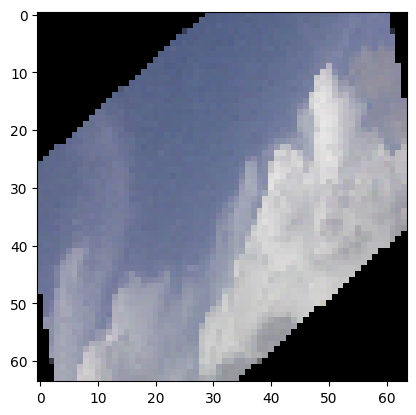

In [43]:
image, label=next(iter(dataloader_train))
# print(image.shape)

# see one image
image=image.squeeze().permute(1,2,0)
plt.imshow(image)

In [48]:
# build network

class ConvNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        
        # define extractor
        self.extractor=nn.Sequential(
            nn.Conv2d(3, 32 ,kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32,64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )

        # define classifier     
        self.classifier=nn.Linear(64*16*16,num_classes)

#     define forward method
    def forward(self,x):
        x=self.extractor(x)
        x=self.classifier(x)
        return x

In [49]:
# initiate model
model=ConvNet(num_classes=7)

# define loss
criterion=nn.CrossEntropyLoss()

# optimizer
optimizer=optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# training loop
for epoch in range(10):
    acc_loss=0.0
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        out=model(images)
        loss=criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        acc_loss+=loss.item()
        
    epoch_loss=running_loss/len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

In [72]:
# load test data
test_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64))
])

test_dataset=ImageFolder("../input/cloud-type-classification2/images/",
                         transform=test_transform)
test_dataloader=DataLoader(test_dataset,shuffle=True, batch_size=16)

In [ ]:
# metrics
metric_precision=Precision(task="multiclass", num_classes=7)
metric_recall=Recall(task="multiclass", num_classes=7)

model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        out= model(images)
        _, preds=torch.max(out,1)
        metric_precision(preds,labels)
        metric_recall(preds,labels)

precision=metric_precision.compute()
recall=metric_recall.compute()

print(f"Precision: {precision}")
print(f"Recall: {recall}")